#### This is the experiment and graph code of OthelloGPT using SAE.

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# Imports
import torch
import matplotlib.pyplot as plt
from utils.dataloaders import get_dataloader
import utils.dataloaders
from tqdm import tqdm
from utils.game_engine import history_to_legal_moves
import utils.game_engine
from torcheval.metrics import BinaryAUROC
import pickle as pkl
import os
import sys
import numpy as np
import seaborn as sns
import analysis
from neel_plotly import line, scatter, imshow, histogram
import kaleido


c:\Users\ALTjasonspeed\.conda\envs\othellogpt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ALTjasonspeed\.conda\envs\othellogpt\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
# GPU acceleration
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# test
with open("trained_model_full_114514.pkl", "rb") as f:
    gpt = torch.load(f)

# print(gpt.state_dict())
for key, val in gpt.state_dict().items():
    print(f"{key} : {val.shape}")

#### Train linear_probe on all layers

In [8]:
from model_training import full_probe_run
ids = ["9999", "114514", "20040805"]

for id in ids:
    layers = list(range(0, 12))
    for layer in layers:
        full_probe_run(layer, save=True, trained_model_location=f"trained_model_full_12_{id}.pkl")

1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [01:39<00:00, 15.79it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:01<00:00, 12.84it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:15<00:00, 11.50it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:36<00:00, 10.02it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:49<00:00,  9.21it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [03:00<00:00,  8.68it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [03:13<00:00,  8.06it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [03:33<00:00,  7.34it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [03:46<00:00,  6.91it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [04:03<00:00,  6.41it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [04:19<00:00,  6.03it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [04:38<00:00,  5.61it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [01:40<00:00, 15.58it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:02<00:00, 12.81it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:17<00:00, 11.40it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:37<00:00,  9.92it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:49<00:00,  9.21it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [03:00<00:00,  8.67it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [03:12<00:00,  8.11it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [03:30<00:00,  7.44it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [03:52<00:00,  6.73it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [04:02<00:00,  6.45it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [04:19<00:00,  6.02it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [04:34<00:00,  5.70it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [01:38<00:00, 15.86it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:01<00:00, 12.84it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:16<00:00, 11.47it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:36<00:00,  9.98it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:49<00:00,  9.23it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [02:59<00:00,  8.72it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [03:13<00:00,  8.10it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [03:28<00:00,  7.49it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [03:43<00:00,  6.99it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [04:01<00:00,  6.48it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [04:15<00:00,  6.12it/s]


1 64 2000
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 2000 steps.


100%|██████████| 1563/1563 [04:33<00:00,  5.71it/s]


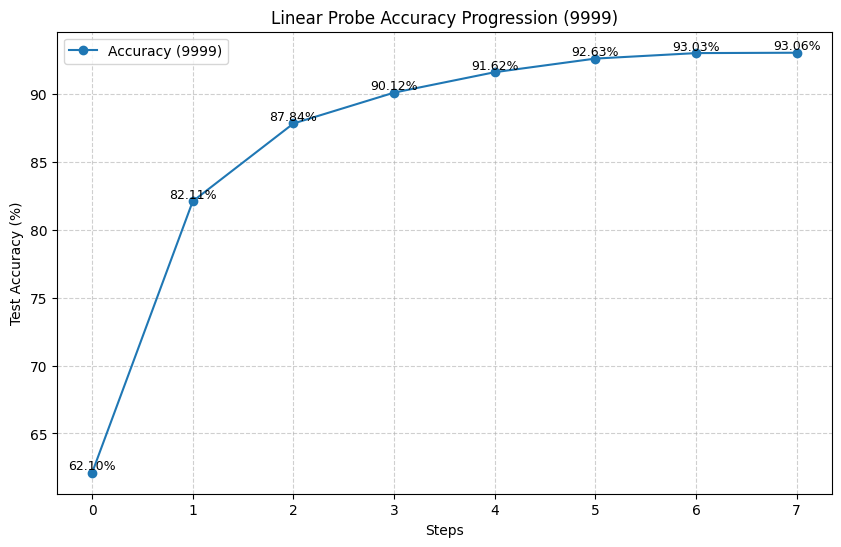

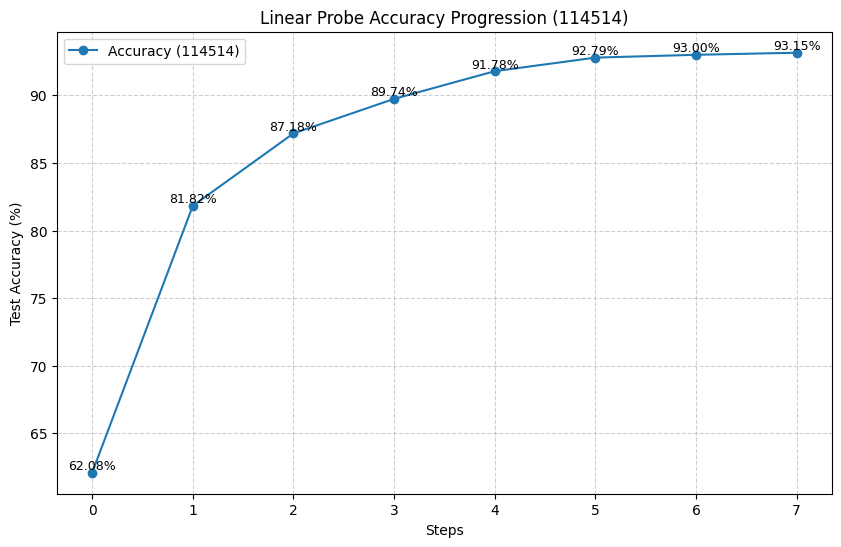

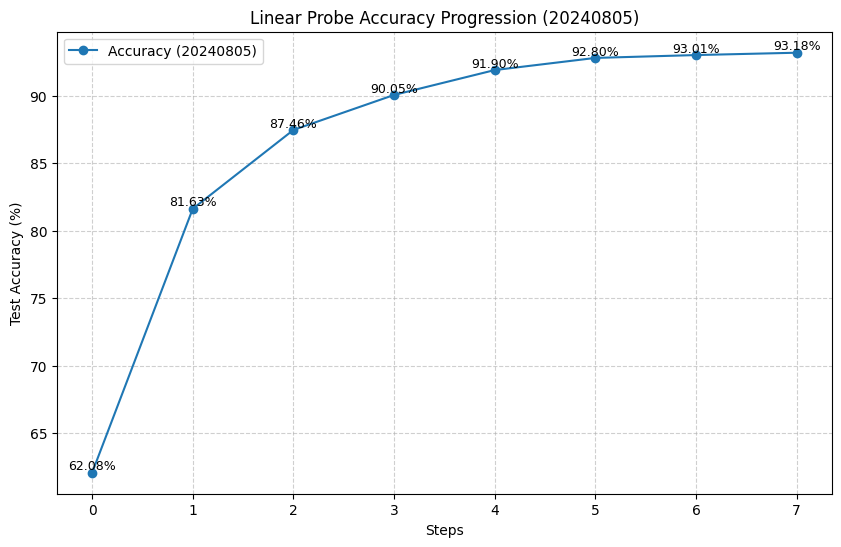

In [7]:
import re
ids = ["9999", "114514", "20240805"]
pattern_1500 = re.compile(r"Train loss and test accuracy after 1500 steps: .*?, (\d+\.\d+)%")

for id in ids:
    log_file_path = f"{id}_linear_probe_output.log"
    with open(log_file_path, 'r') as f:
        log_content = f.read()
    accuracies = [float(match) for match in pattern_1500.findall(log_content)]
    layers = list(range(len(accuracies)))
    
    plt.figure(figsize=(10, 6))
    plt.plot(layers, accuracies, marker='o', linestyle='-', label=f"Accuracy ({id})")
    for i, acc in enumerate(accuracies):
        plt.text(layers[i], acc, f"{acc:.2f}%", fontsize=9, ha='center', va='bottom')
    plt.title(f"Linear Probe Accuracy Progression ({id})")
    plt.xlabel("Steps")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    output_path = f"data/Picture/Linear_Probe_Accuracy_Progression_{id}.png"
    plt.savefig(output_path, dpi=300)
    print(f"Saved plot to {output_path}")
    plt.show()


In [7]:
layers = list(range(0, 12))
mode = 2 # ["empty", "own", "enemy"]
ids = ["9999", "114514", "20040805"]

for id in ids:
    model_location = f"trained_model_full_12_{id}.pkl"
    with open(model_location, 'rb') as f:
        othello_gpt=torch.load(f, map_location=device)
    for layer in layers:
        # Probe
        probe_path = f"probes/12layer/12_probe_layer_{layer}_{id}_trimmed.pkl"
        full_linear_probe = torch.load(probe_path)
        my_probe_W = full_linear_probe[f'classifier.{mode}.weight'] # (64, 512)
        my_probe_W = my_probe_W.t()
        my_probe_normalised = my_probe_W / my_probe_W.norm(dim=0, keepdim=True) # torch.Size([512, 64])
        my_probe_normalised[:, [27, 28, 35, 36]] = 0.
        # Weight
        weight_in_key = f"blocks.{layer}.mlp_sublayer.proj.weight"
        
        heatmaps_my = []
        w_in = othello_gpt.state_dict()[weight_in_key] # torch.Size([512, 2048])
        w_in /= w_in.norm(dim=0, keepdim=True)
        for neuron in range(0, 2048):
            neuron_weight = w_in[:, neuron]
            heatmaps_my.append((neuron_weight[:, None] * my_probe_normalised).sum(dim=0))
            
        heatmaps_my = torch.stack(heatmaps_my).reshape(-1, 8, 8)
        # print(heatmaps_my.shape)
        heatmaps_my_id = heatmaps_my.std(dim=[1, 2]).argsort(descending=True)[:8]
        heatmaps_my = heatmaps_my[heatmaps_my_id]

        imshow(heatmaps_my,
            facet_col=0,
            y=[i for i in "ABCDEFGH"],
            title=f"12LayerOthelloGPT Cosine sim of {id} Input weights and the my color probe for top layer {layer+1} neurons",
            facet_labels=[f"L{layer+1}N{n.item()}" for n in heatmaps_my_id])

#### Histogram

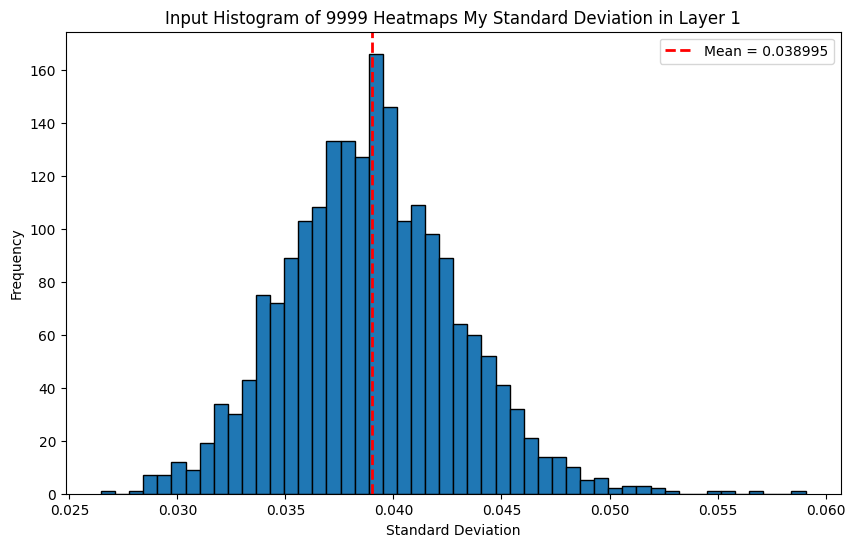

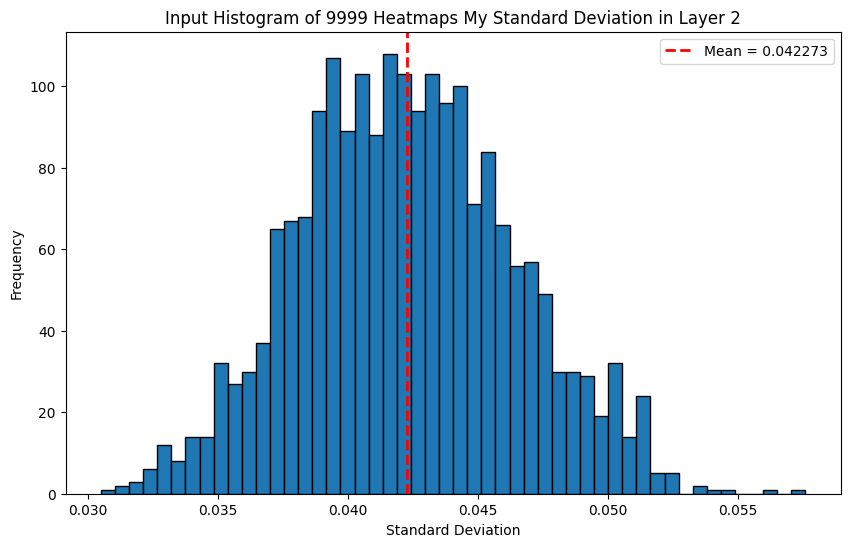

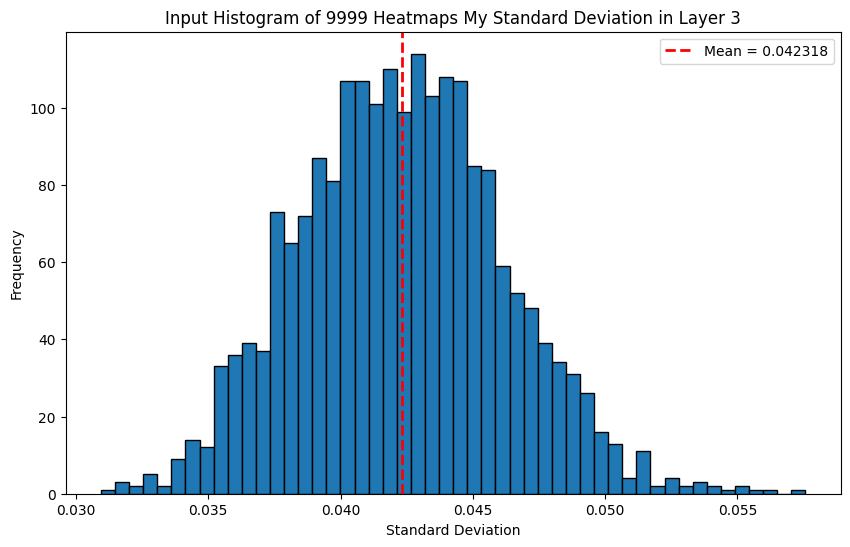

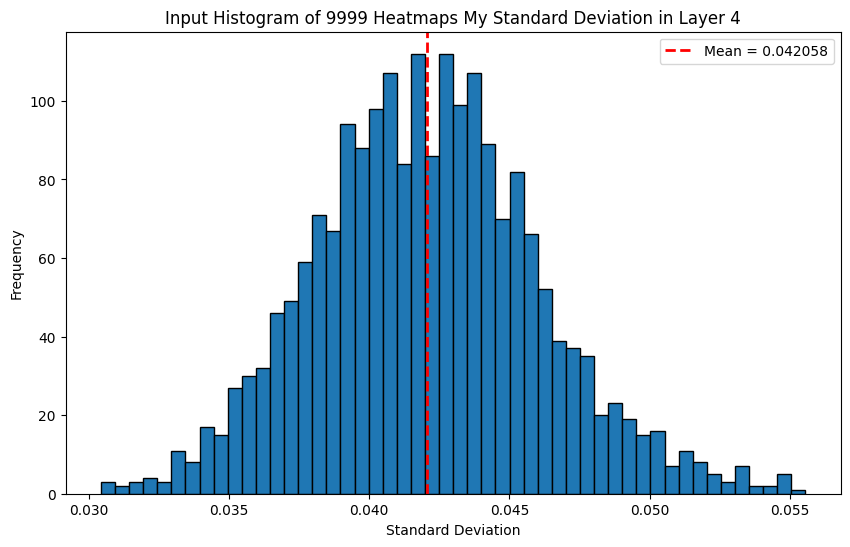

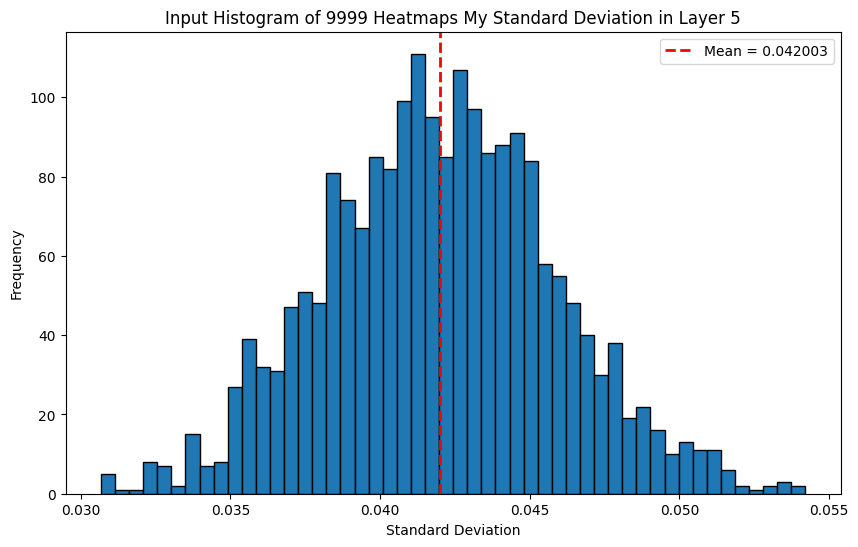

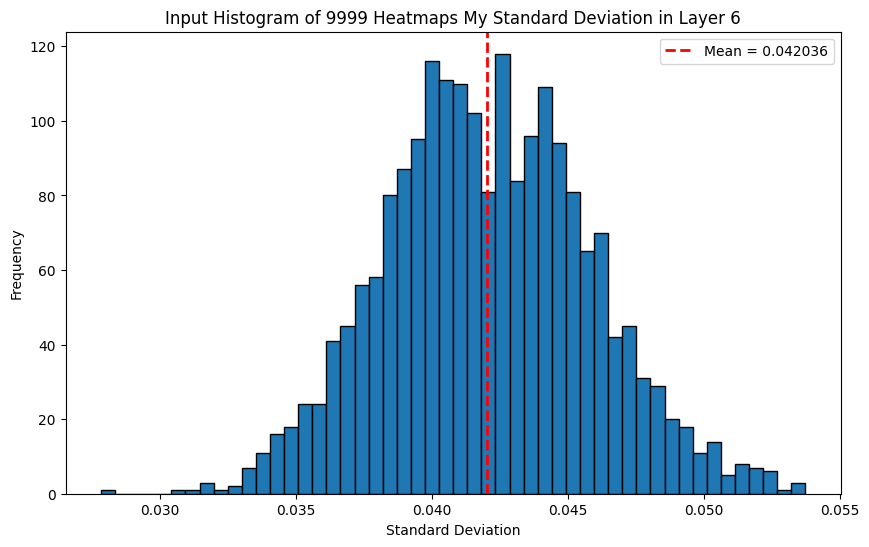

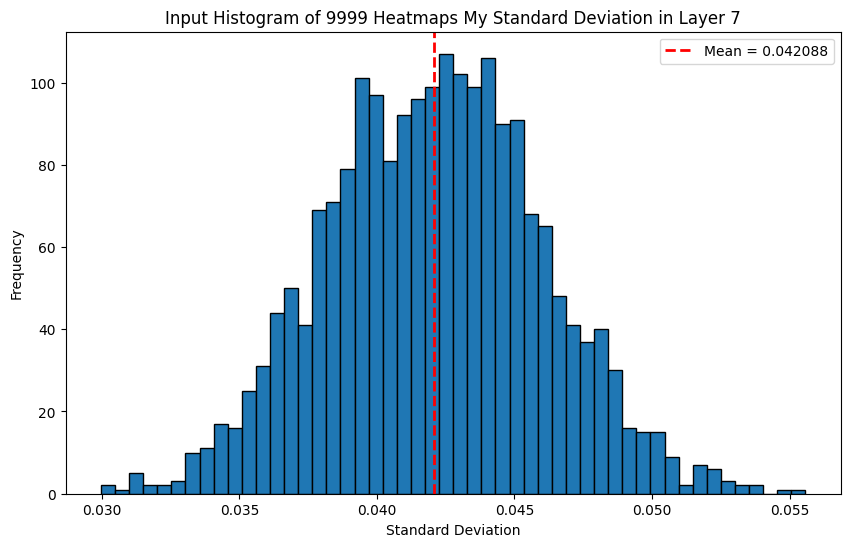

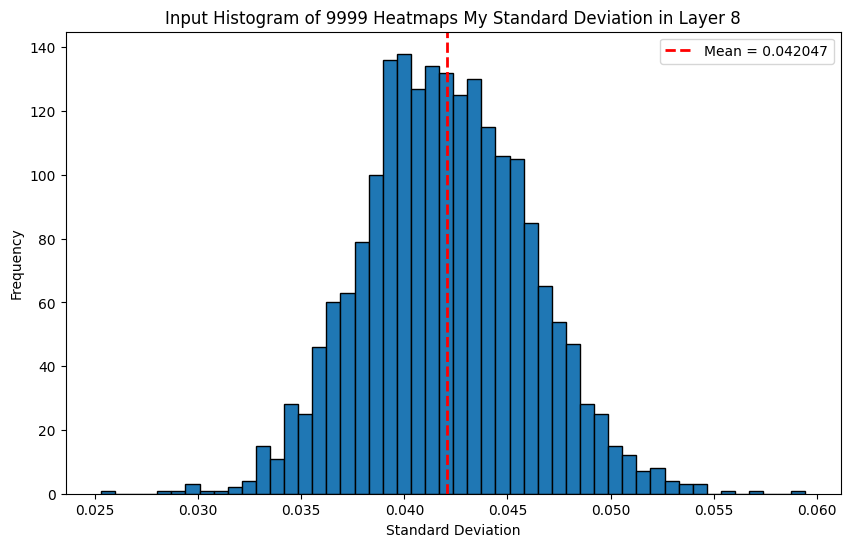

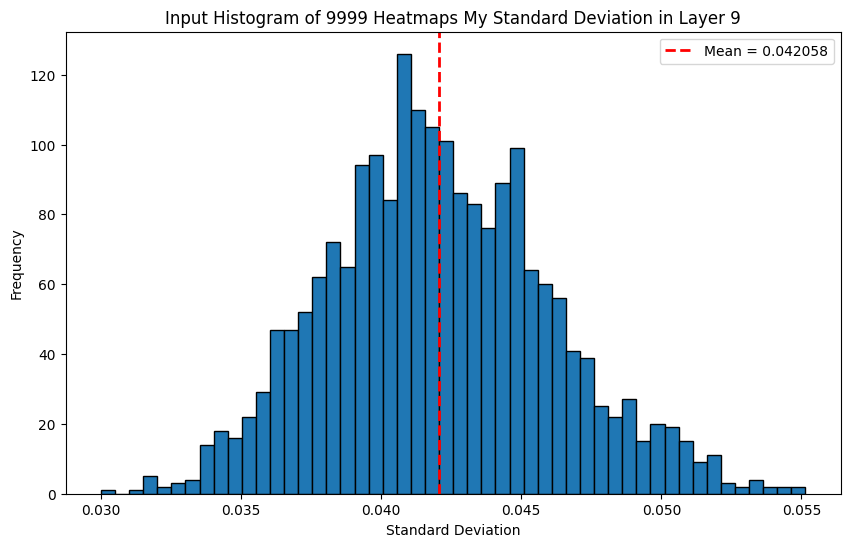

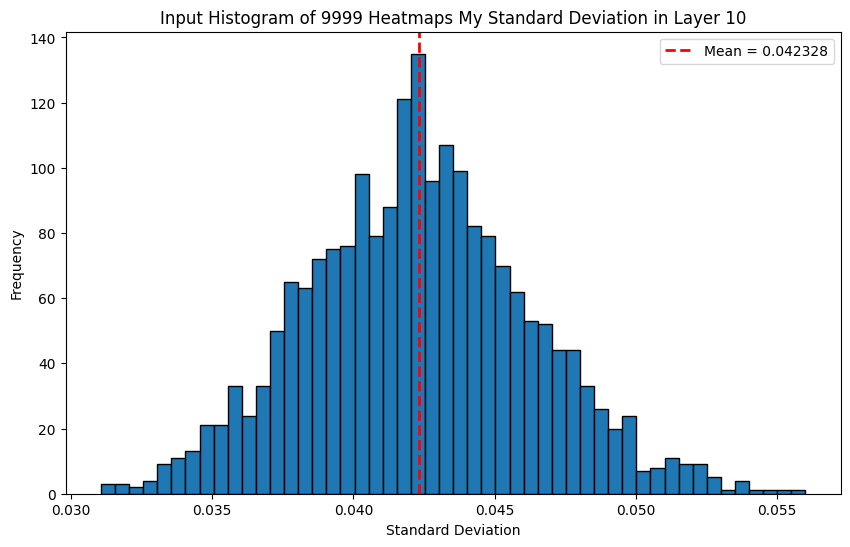

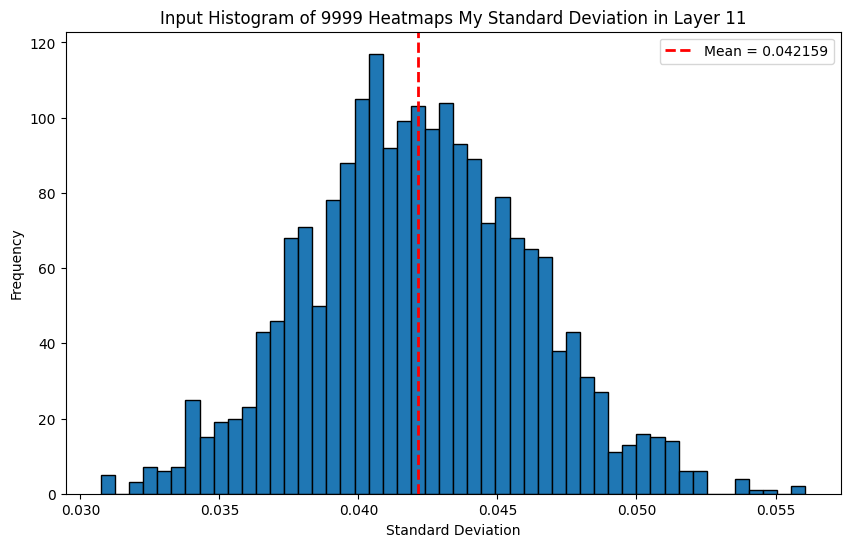

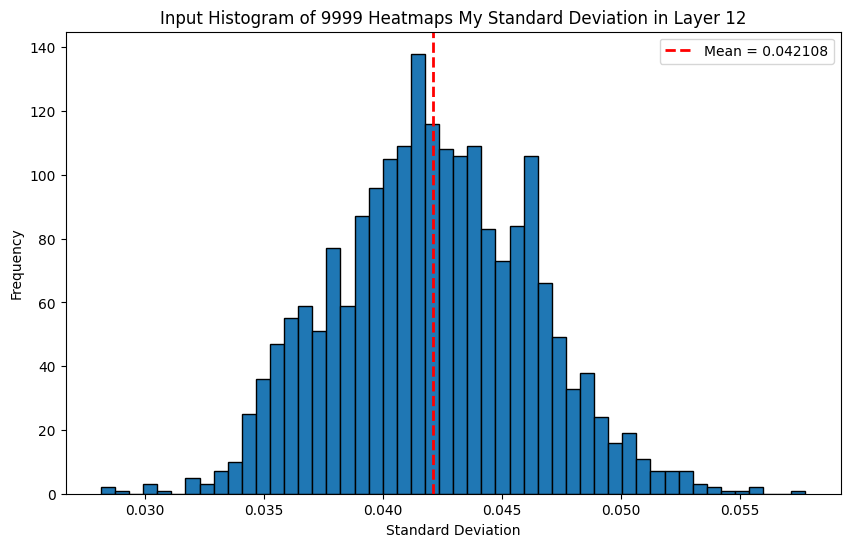

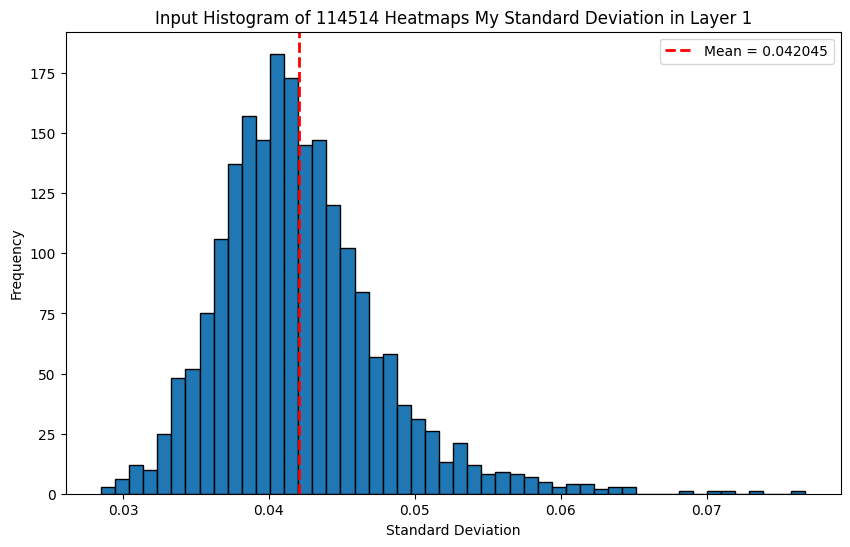

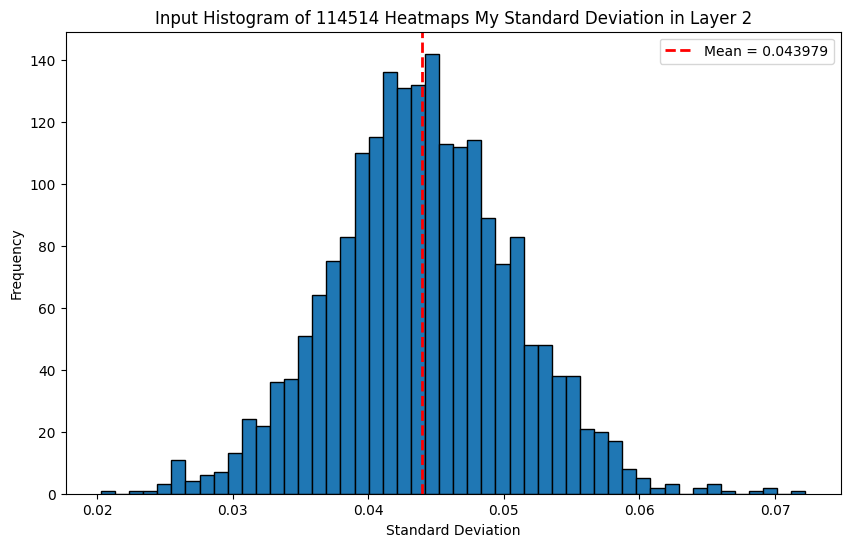

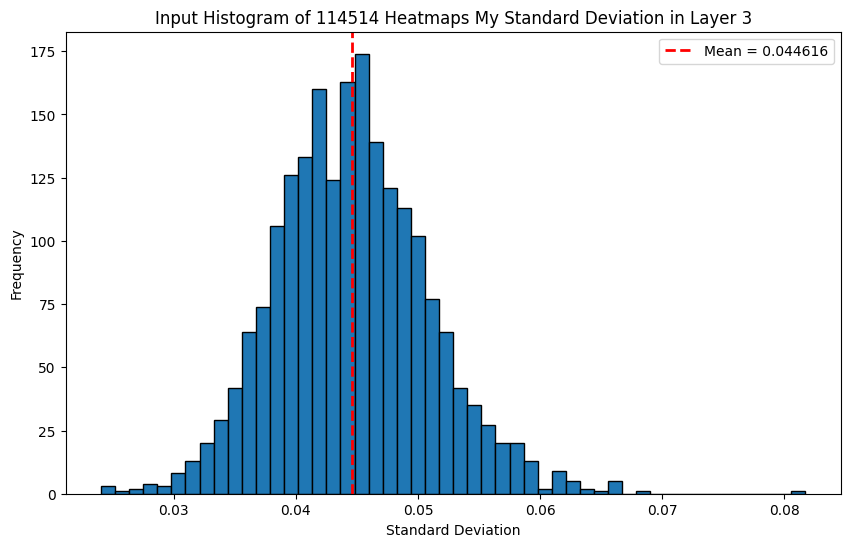

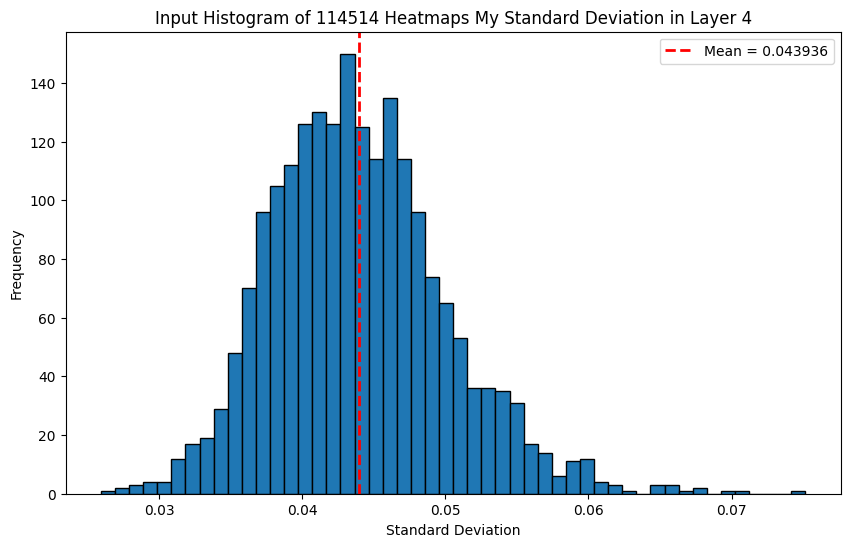

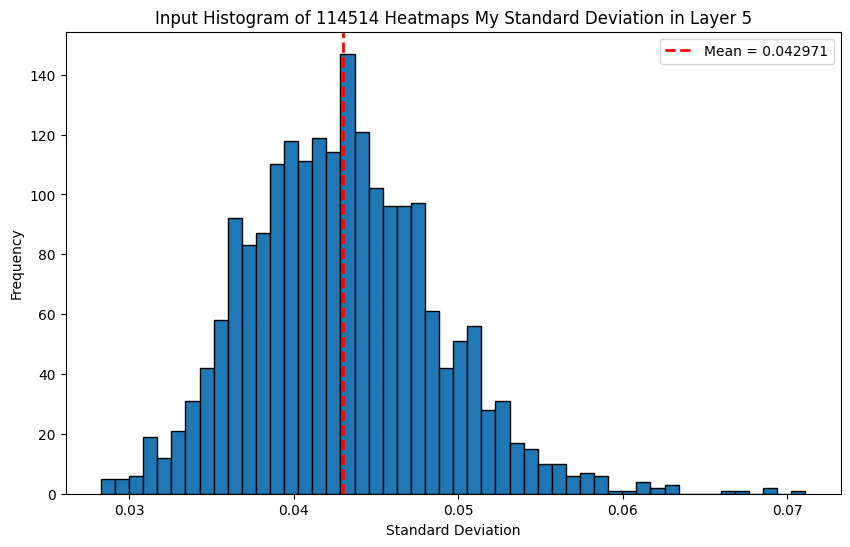

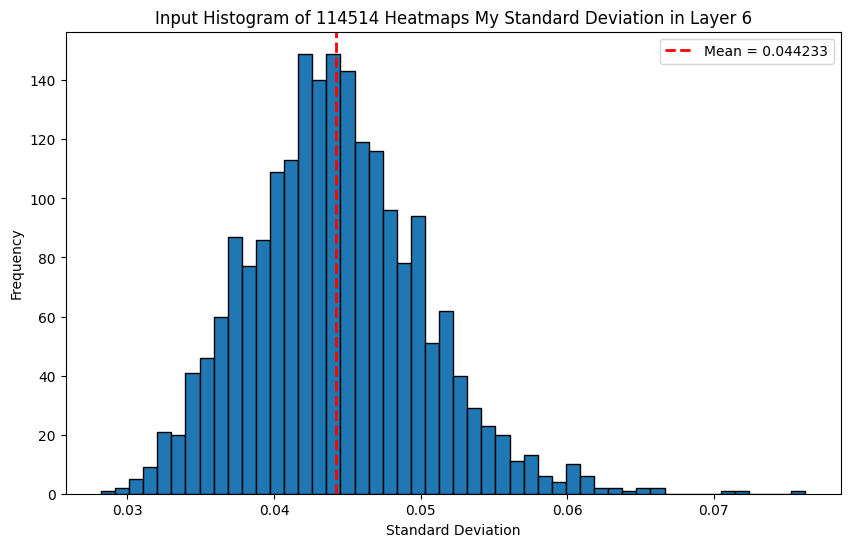

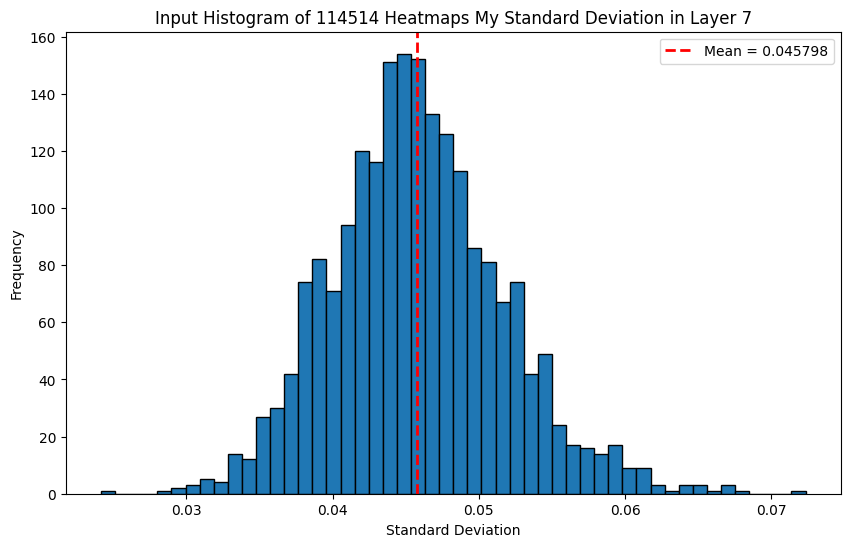

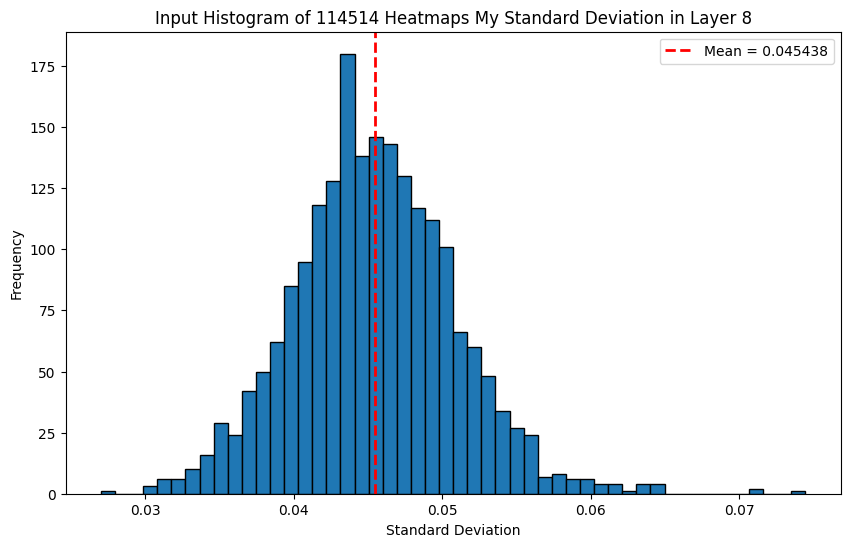

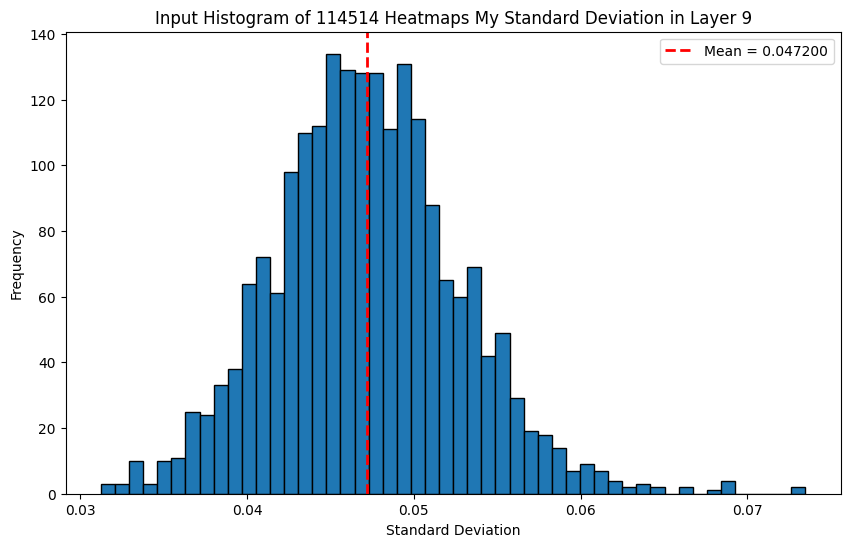

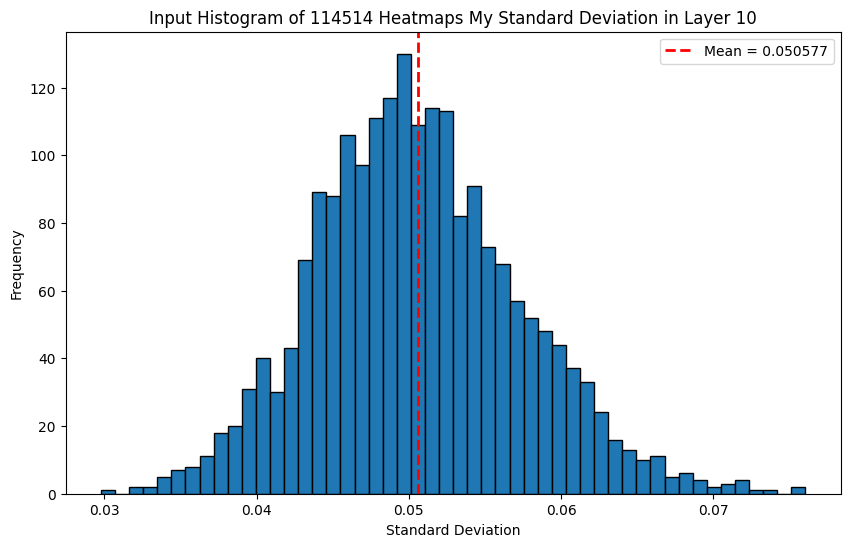

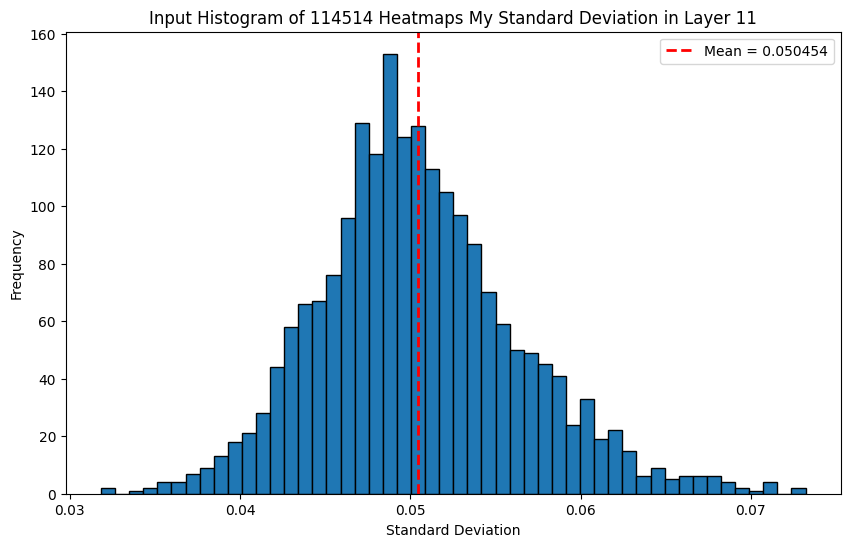

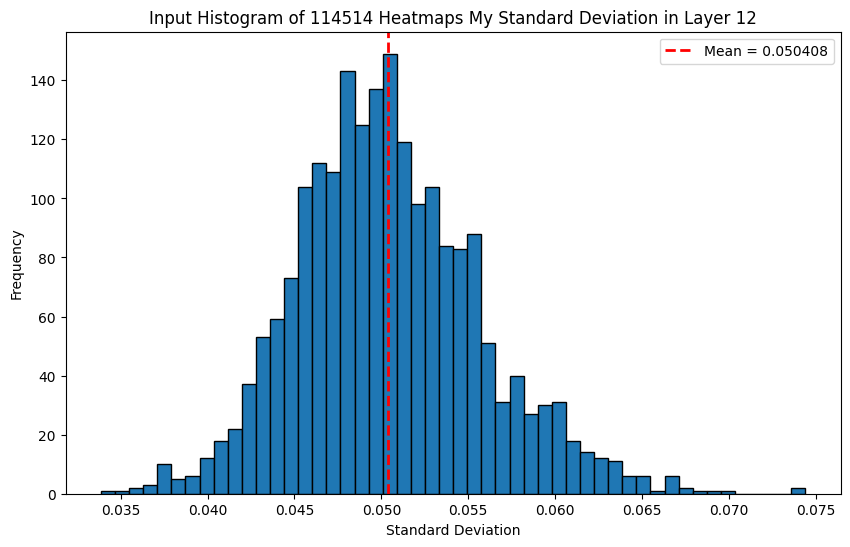

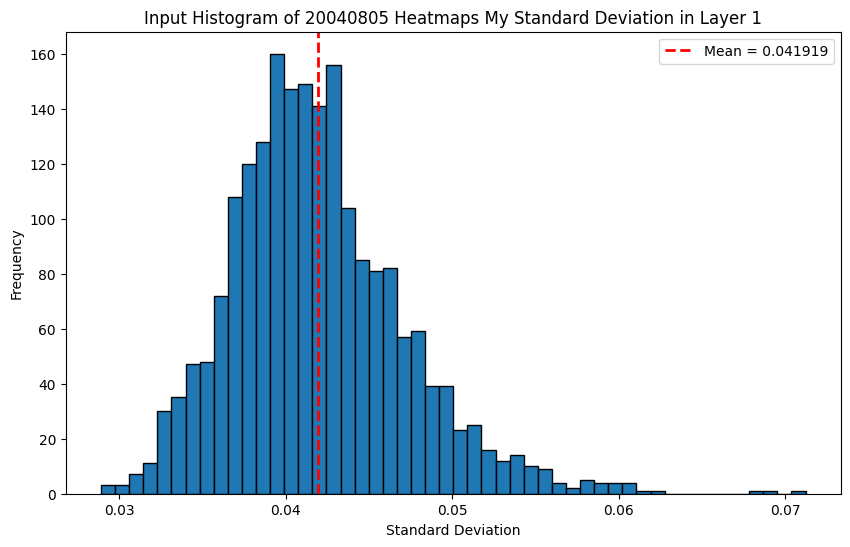

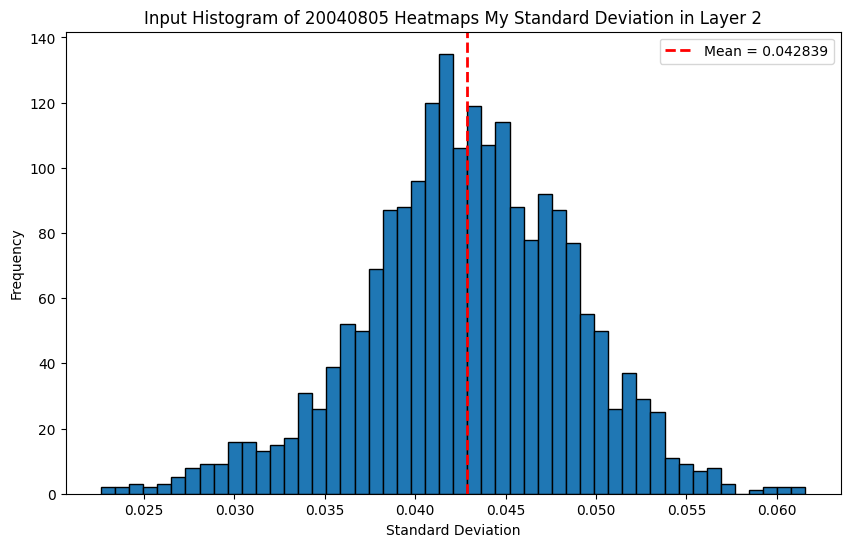

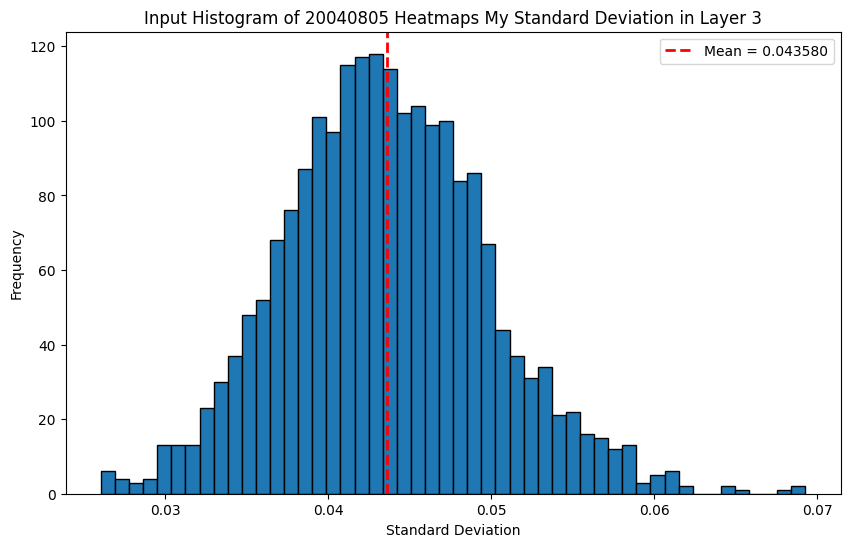

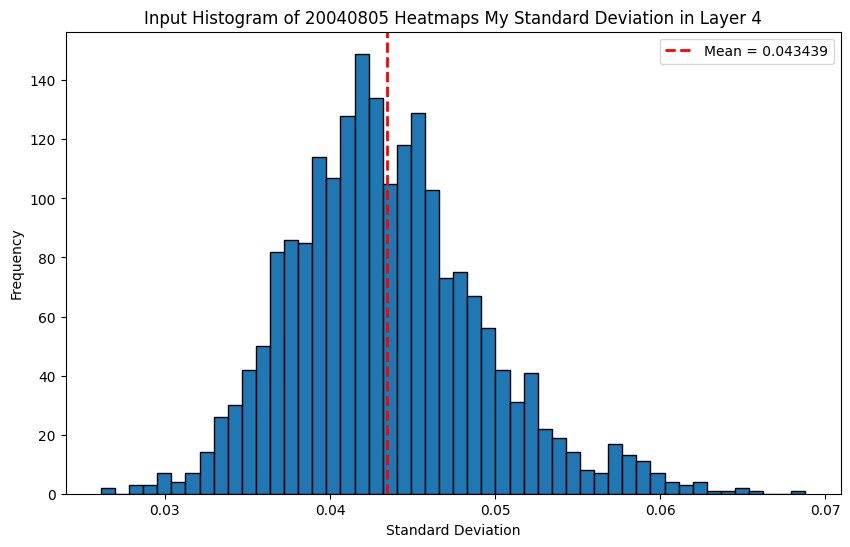

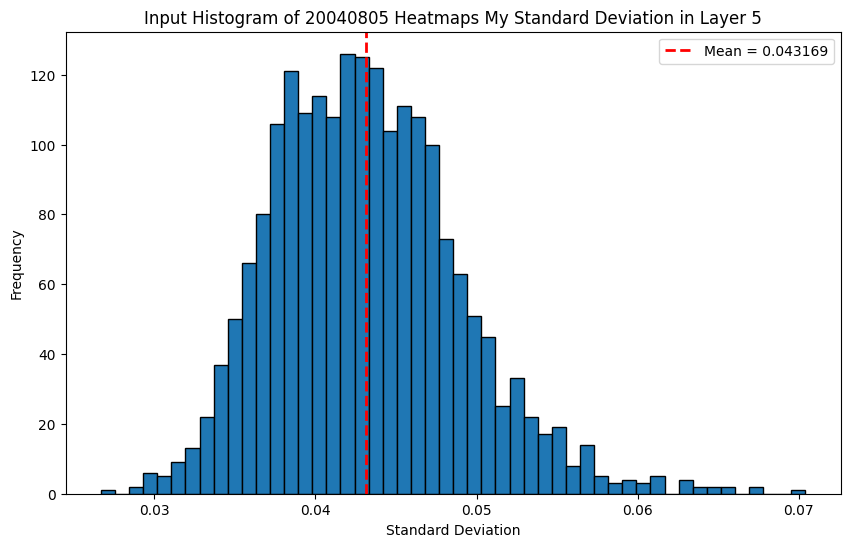

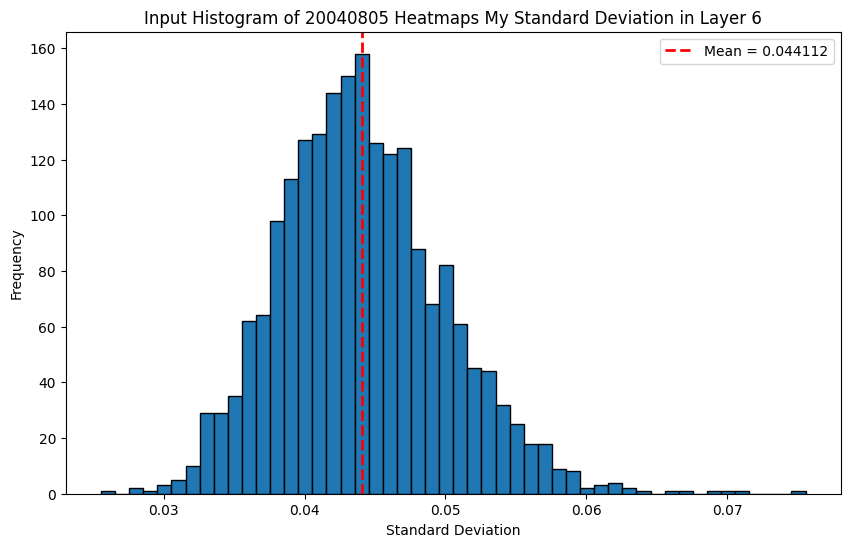

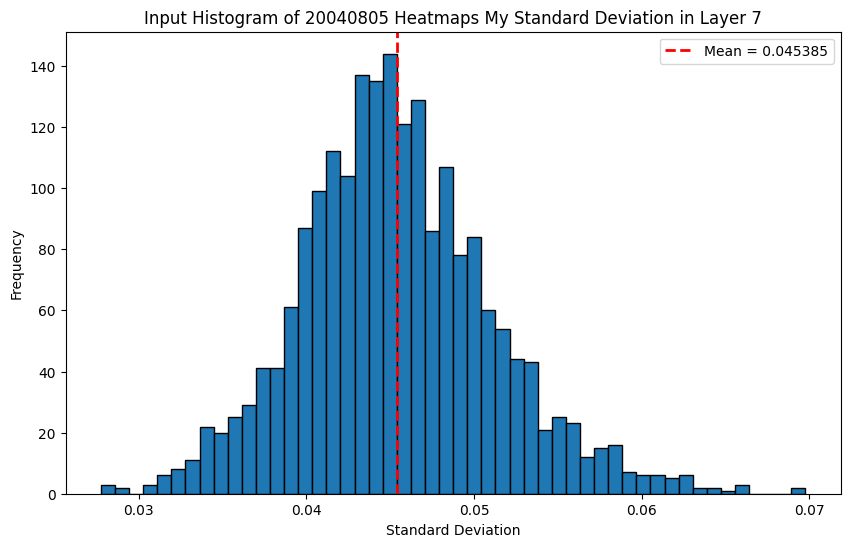

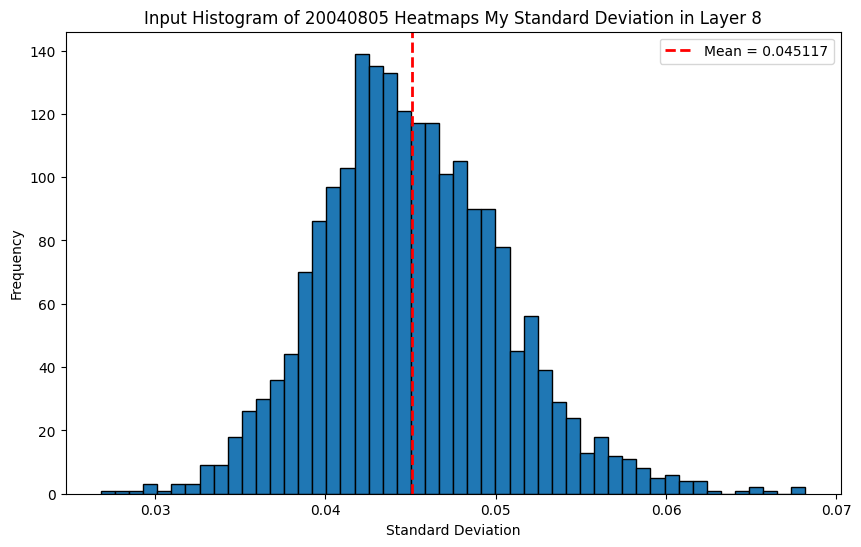

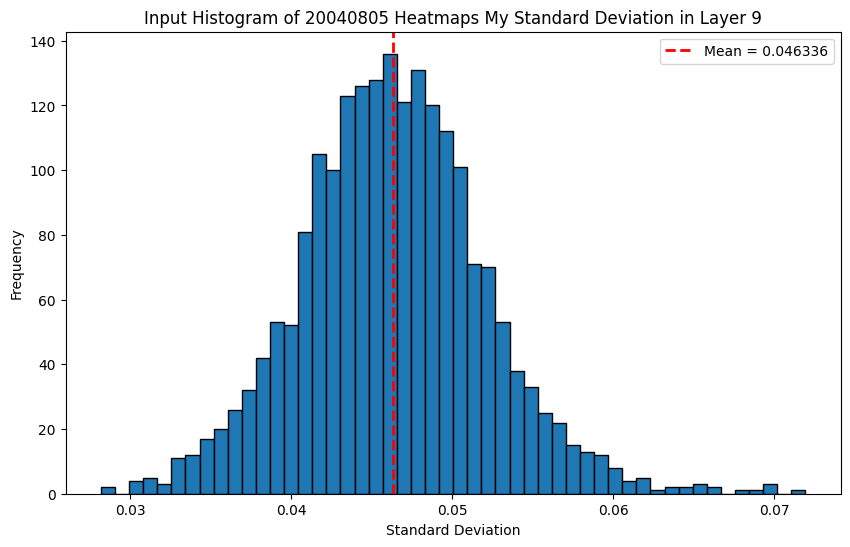

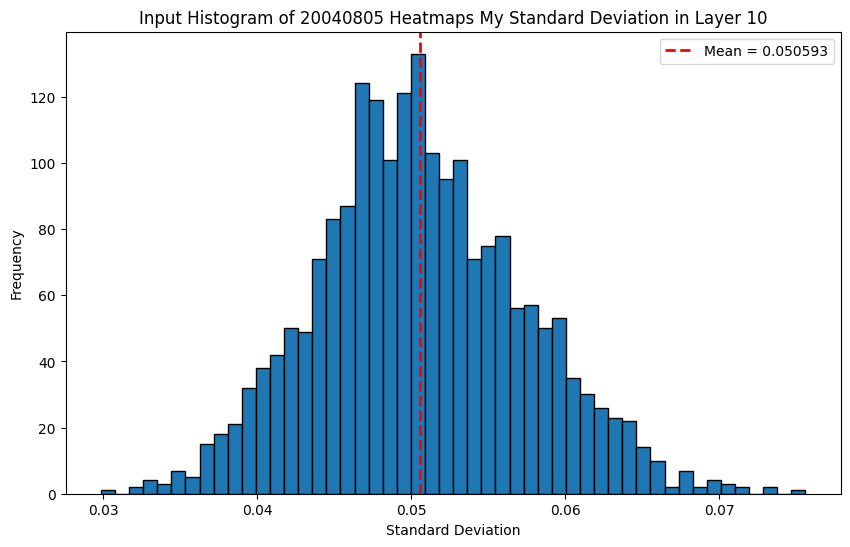

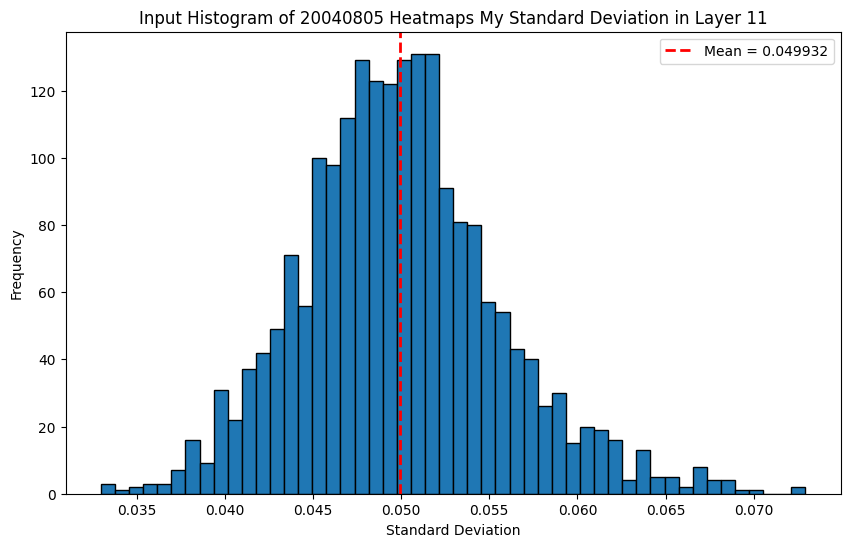

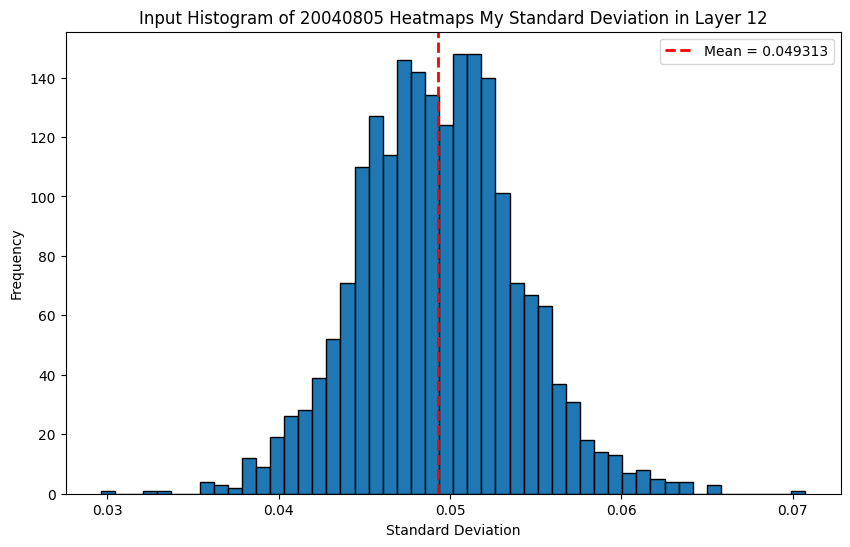

In [5]:
layers = list(range(0,12))
mode = 2 # ["empty", "own", "enemy"]
ids = ["9999", "114514", "20040805"]

for id in ids:
    model_location = f"trained_model_full_12_{id}.pkl"
    with open(model_location, 'rb') as f:
        othello_gpt=torch.load(f, map_location=device)
    for layer in layers:
        # Probe
        probe_path = f"probes/12layer/12_probe_layer_{layer}_{id}_trimmed.pkl"
        full_linear_probe = torch.load(probe_path)
        my_probe_W = full_linear_probe[f'classifier.{mode}.weight'] # (64, 512)
        my_probe_W = my_probe_W.t()
        my_probe_normalised = my_probe_W / my_probe_W.norm(dim=0, keepdim=True) # torch.Size([512, 64])
        my_probe_normalised[:, [27, 28, 35, 36]] = 0.
        # Weight
        weight_in_key = f"blocks.{layer}.mlp_sublayer.proj.weight"
        
        heatmaps_my = []
        w_in = othello_gpt.state_dict()[weight_in_key] # torch.Size([512, 2048])
        w_in /= w_in.norm(dim=0, keepdim=True)
        for neuron in range(0, 2048):
            neuron_weight = w_in[:, neuron]
            heatmaps_my.append((neuron_weight[:, None] * my_probe_normalised).sum(dim=0))
            
        heatmaps_my = torch.stack(heatmaps_my).reshape(-1, 8, 8)
        
        if False:
            heatmaps_blank_std = heatmaps_blank.std(dim=[1, 2])
            mean_value = heatmaps_blank_std.mean().item()

            plt.figure(figsize=(10, 6))
            plt.hist(heatmaps_blank_std.detach().cpu().numpy(), bins=50, edgecolor='black')
            plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_value:.4f}')
            plt.title(f"Input Histogram of Heatmaps Blank Standard Deviation in Layer {layer+1}")
            plt.xlabel("Standard Deviation")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()
        else:
            heatmaps_my_std = heatmaps_my.std(dim=[1, 2])
            mean_value = heatmaps_my_std.mean().item()
            plt.figure(figsize=(10, 6))
            plt.hist(heatmaps_my_std.detach().cpu().numpy(), bins=50, edgecolor='black')
            plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_value:.6f}')
            plt.title(f"Input Histogram of {id} Heatmaps My Standard Deviation in Layer {layer+1}")
            plt.xlabel("Standard Deviation")
            plt.ylabel("Frequency")
            plt.legend()
            output_path = f"data/Picture/12_{id}Histogram_Heatmaps_StandardDeviation_Layer{layer+1}.png"
            plt.savefig(output_path, dpi=300)
            plt.show()

#### Layer by layer probe similarity through Standard Deviation 

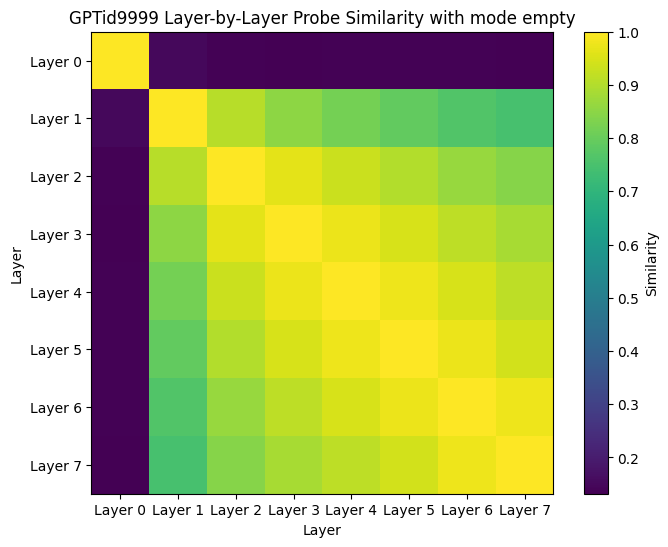

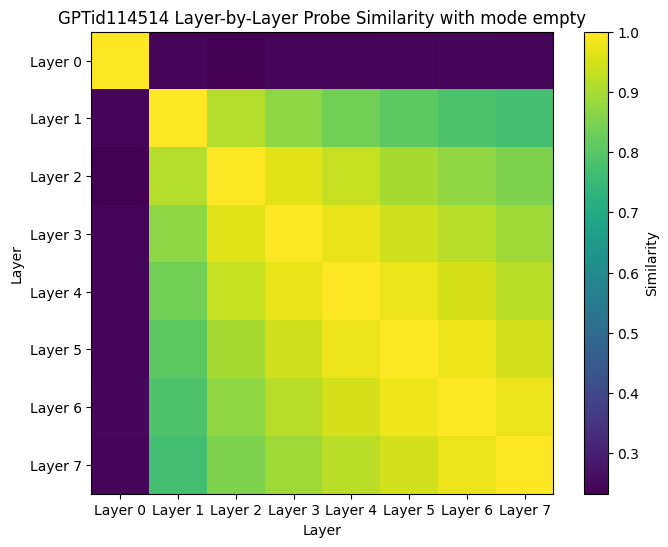

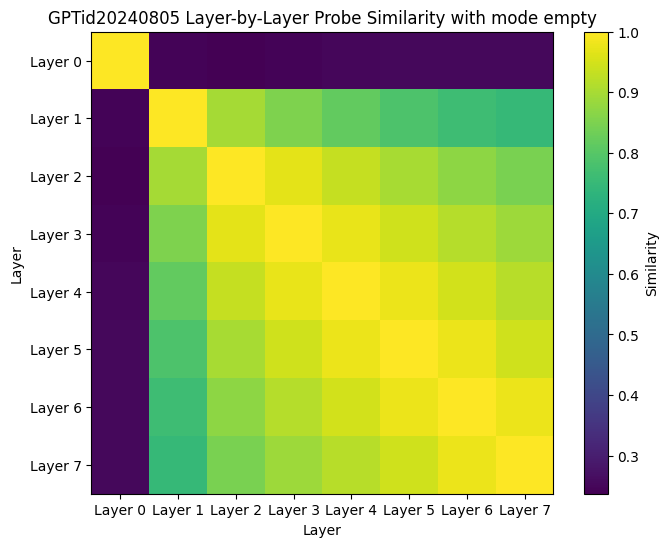

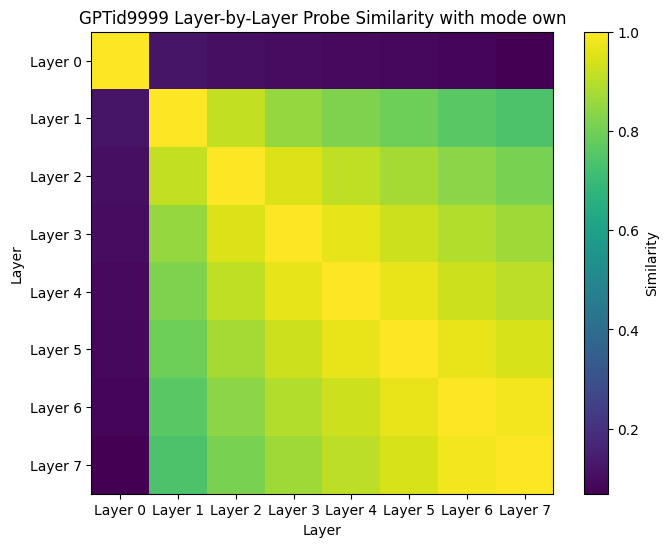

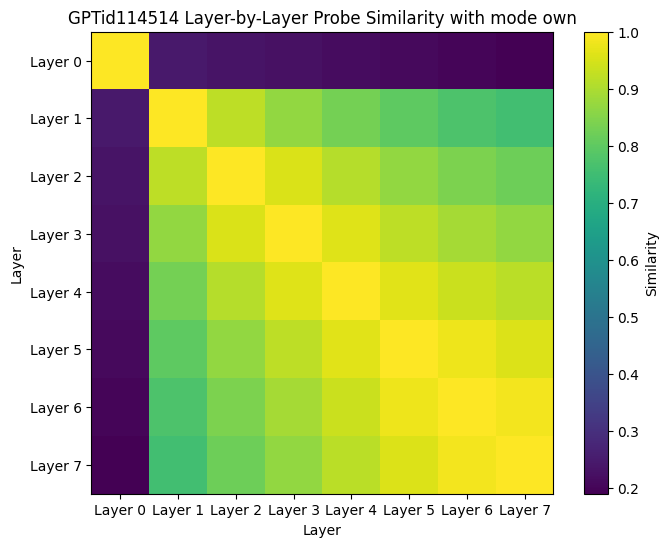

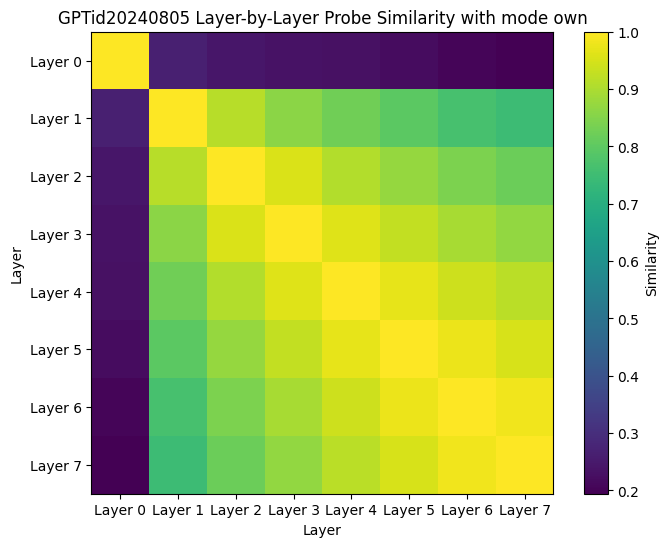

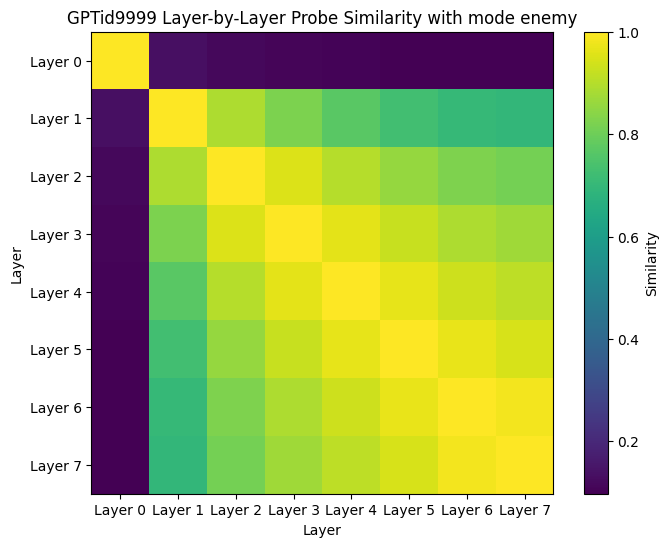

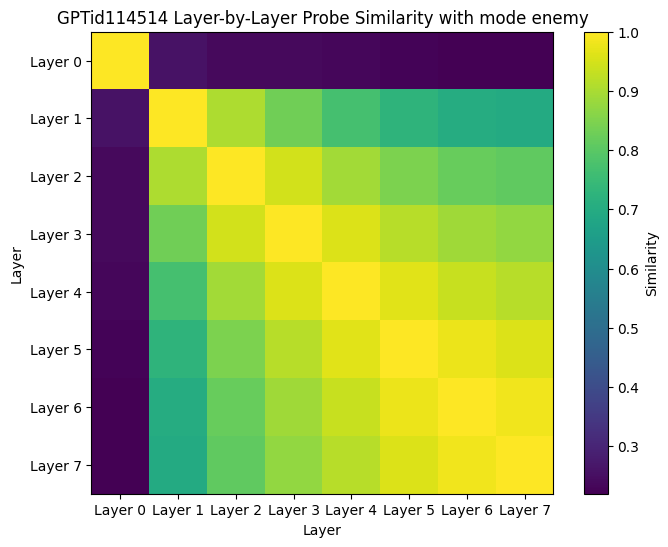

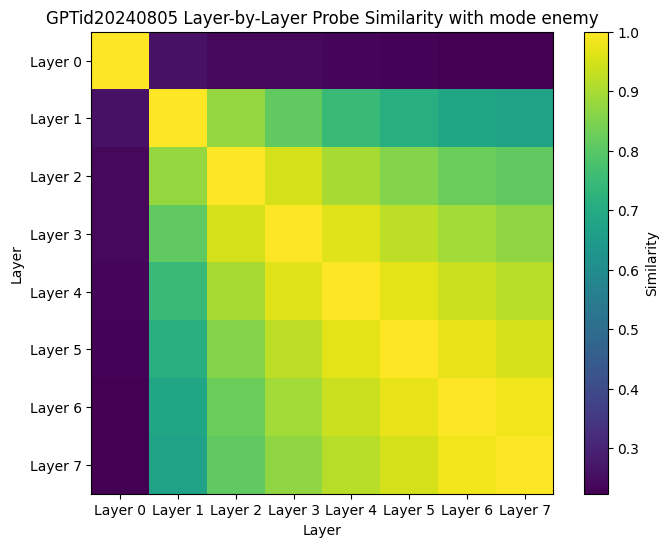

In [14]:
def compute_similarity(probe1, probe2):
    cosine_similarity = torch.sum(probe1 * probe2).item()
    return cosine_similarity

layers = list(range(0, 8))
modes = ["0", "1", "2"] # ["empty", "own", "enemy"]
mode_dict = {"0": "empty", "1": "own", "2": "enemy"}
ids = ["9999", "114514", "20240805"]

for mode in modes:
    for id in ids:
        probes = []
        for layer in layers:
            # Probe
            probe_path = f"probes/probe_layer_{layer}_{id}_trimmed.pkl"
            full_linear_probe = torch.load(probe_path)
            my_probe_W = full_linear_probe[f'classifier.{mode}.weight'] # (64, 512)
            my_probe_W = my_probe_W.t()
            my_probe_normalised = my_probe_W / my_probe_W.norm() # torch.Size([512, 64])
            # my_probe_normalised[:, [27, 28, 35, 36]] = 0.
            probes.append(my_probe_normalised)
        
        # Compute similarity matrix
        num_probes = len(probes)
        similarity_matrix = np.zeros((num_probes, num_probes))
        for i in range(num_probes):
            for j in range(num_probes):
                similarity_matrix[i, j] = compute_similarity(probes[i], probes[j])

        # Plot the similarity matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar(label="Similarity")
        plt.title(f"GPTid{id} Layer-by-Layer Probe Similarity with mode {mode_dict[mode]}")
        plt.xlabel("Layer")
        plt.ylabel("Layer")
        plt.xticks(range(num_probes), [f"Layer {i}" for i in range(num_probes)])
        plt.yticks(range(num_probes), [f"Layer {i}" for i in range(num_probes)])
        plt.show()
